# Facial Emotion Recognition using DCNN architecture

### Importing the neccessary Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import plot_model
from keras import backend as K
# from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

/opt/homebrew/Caskroom/miniconda/base/envs/TF/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.0)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


## Getting the Dataset

In [13]:
import os
if "fer2013plus" not in os.listdir("."):
    print("Dataset to be downloaded")
    # ! pip install opendatasets
    import opendatasets as od
    dataset_url = "https://www.kaggle.com/datasets/subhaditya/fer2013plus"
    od.download(dataset_url)
else:
    print("Dataset already downloaded")
    for dirpath, dirnames, filenames in os.walk("fer2013plus"):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


Dataset already downloaded
There are 1 directories and 1 images in fer2013plus
There are 1 directories and 0 images in fer2013plus/fer2013plus
There are 2 directories and 0 images in fer2013plus/fer2013plus/fer2013
There are 8 directories and 0 images in fer2013plus/fer2013plus/fer2013/test
There are 0 directories and 51 images in fer2013plus/fer2013plus/fer2013/test/contempt
There are 0 directories and 167 images in fer2013plus/fer2013plus/fer2013/test/fear
There are 0 directories and 900 images in fer2013plus/fer2013plus/fer2013/test/surprise
There are 0 directories and 856 images in fer2013plus/fer2013plus/fer2013/test/sadness
There are 0 directories and 2597 images in fer2013plus/fer2013plus/fer2013/test/neutral
There are 0 directories and 1827 images in fer2013plus/fer2013plus/fer2013/test/happiness
There are 0 directories and 644 images in fer2013plus/fer2013plus/fer2013/test/anger
There are 0 directories and 57 images in fer2013plus/fer2013plus/fer2013/test/disgust
There are 8 d

In [2]:
for dirpath, dirnames, filenames in os.walk("fer2013plus/fer2013/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in 'fer2013plus/fer2013/'
There are 8 directories and 0 images in 'fer2013plus/fer2013/train'
There are 0 directories and 7528 images in 'fer2013plus/fer2013/train/happiness'
There are 0 directories and 191 images in 'fer2013plus/fer2013/train/disgust'
There are 0 directories and 3562 images in 'fer2013plus/fer2013/train/surprise'
There are 0 directories and 652 images in 'fer2013plus/fer2013/train/fear'
There are 0 directories and 165 images in 'fer2013plus/fer2013/train/contempt'
There are 0 directories and 10308 images in 'fer2013plus/fer2013/train/neutral'
There are 0 directories and 2466 images in 'fer2013plus/fer2013/train/anger'
There are 0 directories and 3514 images in 'fer2013plus/fer2013/train/sadness'
There are 8 directories and 0 images in 'fer2013plus/fer2013/test'
There are 0 directories and 1827 images in 'fer2013plus/fer2013/test/happiness'
There are 0 directories and 57 images in 'fer2013plus/fer2013/test/disgust'
There are 0 direc

In [3]:
# tf.random.set_seed(42)
# datagen_whole = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# train_data = datagen_whole.flow_from_directory("fer2013plus/fer2013/train/",
#                                                batch_size=128,
#                                                target_size=(48,48),
#                                                shuffle=True,
#                                                class_mode="sparse",
#                                                color_mode="grayscale")

# test_data = datagen_whole.flow_from_directory("fer2013plus/fer2013/test/",
#                                                batch_size=128,
#                                                target_size=(48,48),
#                                                shuffle=True,
#                                                class_mode="sparse",
#                                                color_mode="grayscale")                                               

# train_data_feature=[]
# train_label=[]

# test_data_feature=[]
# test_label=[]

# c=0
# x=0
# while c<len(train_data):
#     x = train_data.next()
#     for i in range(0,x[0].shape[0]):
#         train_data_feature.append(x[0][i])
#         train_label.append(int(x[1][i]))
#     c+=1
# # len(train_data_feature),len(train_label)


# c=0
# x=0
# while c<len(test_data):
#     x = test_data.next()
#     for i in range(0,x[0].shape[0]):
#         test_data_feature.append(x[0][i])
#         test_label.append(int(x[1][i]))
#     c+=1
# # len(test_data_feature),len(test_label)

# train_data_reshape = np.reshape(train_data_feature,(28386,48*48))
# # test_data_reshape = np.reshape(test_data_feature,(7099,48*48))


# from imblearn.over_sampling import RandomOverSampler
# ros1 = RandomOverSampler(random_state=0)
# X_resampled_train, y_resampled_train = ros1.fit_resample(train_data_reshape, train_label)

# # ros2 = RandomOverSampler(random_state=0)
# # X_resampled_test, y_resampled_test = ros2.fit_resample(test_data_reshape, test_label)

# X_train = tf.reshape(X_resampled_train,(X_resampled_train.shape[0],48,48,1))
# # X_test = tf.reshape(X_resampled_test,(X_resampled_test.shape[0],48,48,1))

# xlabel = np.asarray(y_resampled_train)

# ylabel = np.asarray(test_label)

# X_test = test_data_feature


from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir="fer2013plus/fer2013/train/"
test_dir="fer2013plus/fer2013/test/"


train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=128,
                                               target_size=(48,48),
                                               class_mode="categorical",
                                               seed=42)
test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=128,
                                             target_size=(48,48),
                                             class_mode="categorical",
                                             seed=42)

Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


## Building the model and functionising it

In [3]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    # model_in = tf.keras.layers.GaussianNoise(0.5,seed=42)(model_in)
    conv2d_1 = Conv2D(
        filters=128,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        
        kernel_initializer='he_normal',  
        
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(3,3), name='maxpool2d_1')(batchnorm_2)
    
    dropout_1 = Dropout(0.2, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.2, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,  # Increasing learning capacity and feature extraction
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)

    dropout_3 = Dropout(0.3, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    
    dense_1 = Dense(
        128,   # 128 input neurons
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

In [4]:
model = build_dcnn(input_shape=(48,48,1), num_classes=8)
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       3328      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        73792     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                   

In [15]:
base_model = tf.keras.applications.vgg19.VGG19(include_top=False)
base_model.build(input_shape=(48,48,3))

In [16]:
# ! pip install visualkeras
import visualkeras

visualkeras.layered_view(base_model)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [6]:
# import visualkeras
# # from PIL import ImageFont
# from collections import defaultdict

# color_map = defaultdict(dict)
# color_map[tf.keras.layers.Conv2D]['fill'] = 'red'
# color_map[tf.keras.layers.Input]['fill'] = 'gray'
# color_map[tf.keras.layers.Dropout]['fill'] = 'pink'
# color_map[tf.keras.layers.MaxPooling2D]['fill'] = 'orange'
# color_map[tf.keras.layers.Dense]['fill'] = 'black'
# color_map[tf.keras.layers.Flatten]['fill'] = 'blue'

# font1 = ImageFont.truetype("arial.ttf", 32)
# x = visualkeras.layered_view(model,font=font1,legend=True,color_map=color_map)
# # x.convert("RGB")
# x

# # from PIL import ImageFont

# # font1 = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
# # print(font1)
# # visualkeras.layered_view(model).show()  # font is optional!


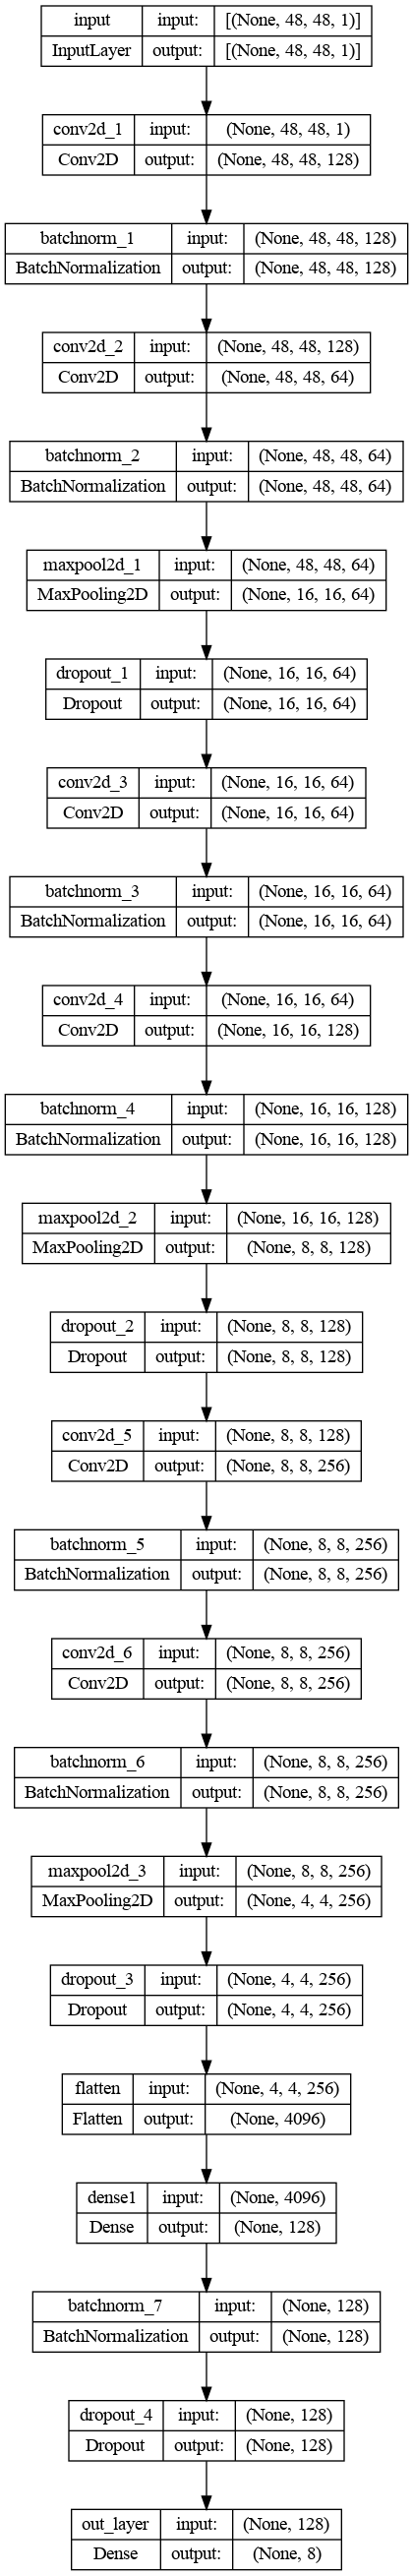

In [7]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [8]:
# def myprint(s):
#     with open('modelsummary.txt','a') as f:
#         print(s, file=f)

# model.summary(print_fn=myprint)

In [9]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=optimizers.Adam(0.01),
             metrics=["accuracy"])

## Writing Callbacks

In [10]:
#Callback functions
early_stopping = EarlyStopping(
    monitor='val_loss',    
    min_delta=0.00001,      
    patience=4,            
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',  #val_loss no overfitting   
    min_delta=0.0001,  
    mode="min",
    factor=0.5,                 
    patience=2,                 
    min_lr=1e-7,                
    verbose=1                   
)

checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', 
                         verbose=1, save_best_only=True, mode='max')

In [15]:
import time

In [9]:
# aug_train_ds = aug_datagen.flow_from_directory(train_dir,
#                                                target_size=target_size,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale",
#                                               class_mode="categorical",
#                                               subset="training")
# aug_validation_ds = aug_datagen.flow_from_directory(train_dir,
#                                                target_size=target_size,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale",
#                                               class_mode="categorical",
#                                               subset="validation")

## Fitting the model

In [10]:
#Fitting the data
start = time.time()

history = model.fit(train_data,
                    epochs=30,
                    steps_per_epoch=len(train_data),
                    validation_steps=int(0.25*len(test_data)),
                    batch_size=64,
                    validation_data = (test_data),
                    validation_batch_size=64,
                    callbacks=[early_stopping,lr_scheduler, checkpoint])

end=time.time()

Epoch 1/30


UnknownError: Graph execution error:

Detected at node DCNN/conv2d_1/Conv2D defined at (most recent call last):
  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/tmp/ipykernel_4662/1390105209.py", line 4, in <module>

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

CUDNN_STATUS_BAD_PARAM
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4155): 'op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
	 [[{{node DCNN/conv2d_1/Conv2D}}]] [Op:__inference_train_function_5435]

## Saving Model Statistics and Model Weights

In [ ]:
import json
python_obj = eval(str(history.history))
json_object = json.dumps(python_obj,indent=4)
# Writing to sample.json
with open("history_dcnn_t4.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
import json

with open("/content/history_dcnn_t4.json") as file:
    data = json.load(file)
eval(str(history.history))==data

In [11]:
end-start

<Axes: >

In [168]:
model.save("high")

INFO:tensorflow:Assets written to: high/assets


INFO:tensorflow:Assets written to: high/assets


In [ ]:
labels=['Anger', 'Contempt','Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]


In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [ ]:
y_pred = model.predict(train_ds)
y_pred[:10],y_pred.shape

In [ ]:
make_confusion_matrix(train_ds.labels,tf.argmax(y_pred,axis=1),classes=labels,savefig=True)

56/56 [==============================] - 7s 121ms/step - loss: 0.6059 - accuracy: 0.7857


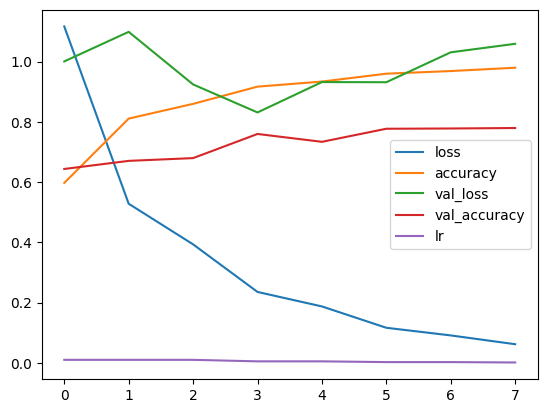

In [166]:
pd.DataFrame(history.history).plot()

In [18]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

In [10]:
model.evaluate(test_data)

56/56 [==============================] - 2s 19ms/step - loss: 0.8312 - accuracy: 0.7598


[0.8312171101570129, 0.7598253488540649]

In [26]:
history.history["accuracy"]

NameError: name 'history' is not defined

In [28]:
history_1 = model.fit(train_data,
          epochs=21+2,
          validation_data=test_data,
          steps_per_epoch=len(train_data),
          validation_steps=int(0.25*len(test_data)),
          initial_epoch=22)

Epoch 23/23


222/222 [==============================] - 17s 63ms/step - loss: 0.0889 - accuracy: 0.9802 - val_loss: 1.5989 - val_accuracy: 0.7881


In [29]:
model.evaluate(test_data)

 1/56 [..............................] - ETA: 2s - loss: 1.5820 - accuracy: 0.8281

56/56 [==============================] - 1s 18ms/step - loss: 1.5988 - accuracy: 0.7881


[1.5988415479660034, 0.7881391644477844]